In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
import matplotlib.pyplot as plt
import torch

In [2]:
# Reproducibility
key = jr.PRNGKey(42)

# Our PINN is a coordinate network in the form of a MLP, mapping from scalar to scalar values
key, init_key = jr.split(key)

model = eqx.nn.MLP(
    in_size= 3,
    out_size="scalar",
    width_size=100,
    depth=4,
    activation=jax.nn.relu,
    key=init_key,
)

2024-10-02 13:16:28.280888: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.68. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
# PARÂMETROS
TAM_TREINO = 200
TF = 80


L = 2
D = 0.0039
p = 0.0453
c0 = 8e3
Dl = D / (p * L**2)

# PONTOS DE COLOCAÇÃO
key, sampling_key = jr.split(key)
pontos_x, pontos_y = torch.FloatTensor(TAM_TREINO).uniform_(-1., 1.), torch.FloatTensor(TAM_TREINO).uniform_(-1., 1.)
pontos_t = torch.FloatTensor(TAM_TREINO).uniform_(0., TF * p)
pontos_spatial_bc = torch.tensor([-1., 1.])
pontos_t_ic = torch.tensor([0.])

print(f'------------- Criando pontos: pontos internos --------------')
pontos_stack = torch.stack((pontos_t, pontos_y, pontos_x), 1)
pontos_stack = pontos_stack.detach().numpy()

print(f'------------- Criando pontos: condição de contorno --------------')
pontos_bc1 = torch.cartesian_prod(pontos_t, pontos_spatial_bc, pontos_x)
pontos_bc2 = torch.cartesian_prod(pontos_t, pontos_y, pontos_spatial_bc)
pontos_bc = torch.cat((pontos_bc1, pontos_bc2), 0)
pontos_bc = pontos_bc.detach().numpy()

print(f'------------- Criando pontos: condição inicial --------------')
pontos_ic = torch.cartesian_prod(pontos_t_ic, pontos_y, pontos_x)
pontos_ic = pontos_ic.detach().numpy()

------------- Criando pontos: pontos internos --------------
------------- Criando pontos: condição de contorno --------------
------------- Criando pontos: condição inicial --------------


In [4]:
# FUNÇÕES DE APOIO
def jacobian(model, x): return jax.grad(model)(x) # COMPUTAÇÃO DO GRADIENTE

def residuo(model, input): # FUNÇÃO RESIDUAL

    grad1 = jax.vmap(jacobian, in_axes=(None, 0))(model, input)
    grad2 = jax.vmap(jacobian, in_axes=(None, 0))(model, grad1)

    u_t = grad1[:, 0]
    u_xx = grad2[:, 1]
    u_yy = grad2[:, 2]

    return u_t - (Dl * (u_xx + u_yy) + jax.vmap(model)(input)), u_xx + u_yy

# FUNÇÃO DE PERDA
def loss_fn(model):
    out_res = residuo(model, pontos_stack)
    loss_res1 = 0.5 * jnp.mean(jnp.square(out_res[0]))
    #loss_res2 = 0.5 * jnp.mean(jnp.square(out_res[1]))

    out_bc = jax.vmap(model)(pontos_bc)
    loss_bc = 0.5 * jnp.mean(jnp.square(out_bc))

    out_ic = jax.vmap(model)(pontos_ic)
    loss_ic = 0.5 * jnp.mean(jnp.square(out_ic - L**3 * jnp.exp(-100 * (pontos_ic[:, 1]**2 + pontos_ic[:, 2]**2))))

    total_loss = loss_res1 + loss_bc + loss_ic

    return total_loss

# Training loop
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

@eqx.filter_jit
def make_step(network, state):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(network)
    updates, new_state = optimizer.update(grad, state, network)
    new_network = eqx.apply_updates(network, updates)
    return new_network, new_state, loss

loss_history = []
for epoch in range(15000):
    model, opt_state, loss = make_step(model, opt_state)
    loss_history.append(loss)
    if epoch % 1000 == 0:
        print(f"Epoch: {epoch}, loss: {loss}")

Epoch: 0, loss: 0.10133430361747742
Epoch: 1000, loss: 0.04237924516201019
Epoch: 2000, loss: 0.028484486043453217
Epoch: 3000, loss: 0.0336303748190403


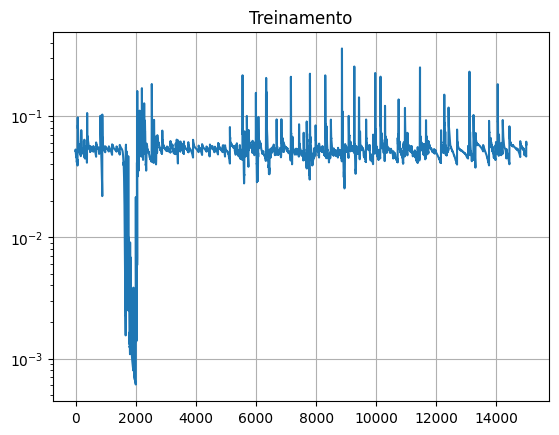

In [10]:
plt.title('Treinamento')
plt.plot(loss_history, label = 'Loss')
plt.yscale('log')
plt.grid()
plt.show()

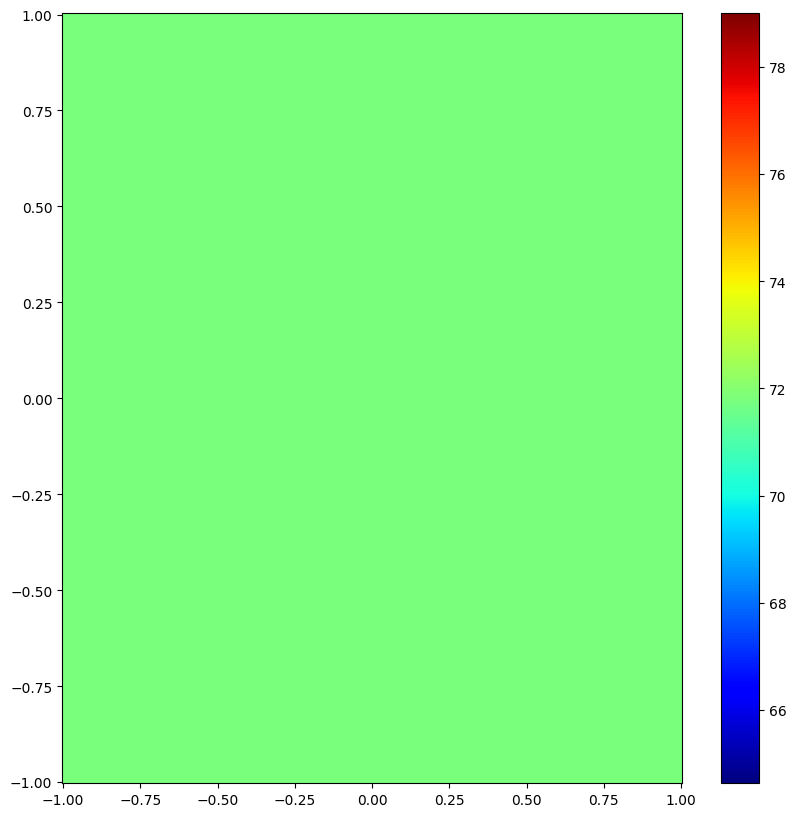

In [16]:
# GERANDO MALHA DO DOMÍNIO
tam = 300
x = torch.linspace(-1., 1., tam, dtype=torch.float32)
y = torch.linspace(-1., 1., tam, dtype=torch.float32)
t = torch.arange(0, TF * p, 1, dtype=torch.float32)
    
input = torch.cartesian_prod(t, y, x)
input = input.detach().numpy()
input = input.reshape(50, tam * tam, 3)
input.shape

# OBTENDO SOLUÇÃO
input = jnp.array(input[3])
pred = jax.vmap(model)(input)
pred = pred.reshape(tam, tam)

#PLOTAGEM
plt.figure(figsize=(10, 10))
plt.pcolormesh(x, y, pred * c0 / L**3, cmap = 'jet')
plt.colorbar()
plt.show()